In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [4]:
%autoreload
cohort = mre_pinn.data.ImagingCohort(['0006'])
cohort.load_images()
cohort.preprocess()
dataset = cohort.to_dataset()
dataset.save_xarrays('../data/NAFLD3')

  0%|          | 0/1 [00:00<?, ?it/s]Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_in.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_water.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_out.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t1_pre_fat.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/t2.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre_raw.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/wave.nii
Loading /ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0006/mre.nii
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]
Loading segmentation model
  0%|          | 0/1 [00:00<?, ?it/s]Correcting metadata on mre_raw
Correcting metadata on wave
Restoring wave
Registering t1_pre_out to mre_raw
Paramete

Resizing mask to (256, 256, 4)
Correcting metadata on t1_pre_in
Correcting metadata on t1_pre_water
Correcting metadata on t1_pre_out
Correcting metadata on t1_pre_fat
Correcting metadata on t2
Correcting metadata on mask
Correcting metadata on mre_raw
Correcting metadata on wave
Correcting metadata on mre
Correcting metadata on mask
100%|██████████| 1/1 [00:48<00:00, 48.11s/it]
Converting t1_pre_in to xarray
Converting t1_pre_water to xarray
Converting t1_pre_out to xarray
Converting t1_pre_fat to xarray
Converting t2 to xarray
Converting mre_raw to xarray
Converting wave to xarray
Converting mre to xarray
Converting mask to xarray
Converting mask to xarray
Writing ../data/NAFLD3/0006/wave.nc
Writing ../data/NAFLD3/0006/mre.nc
Writing ../data/NAFLD3/0006/mre_mask.nc
Writing ../data/NAFLD3/0006/anat.nc
Writing ../data/NAFLD3/0006/anat_mask.nc


In [5]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD3', '0006')
example.metadata

Loading ../data/NAFLD3/0006/wave.nc
Loading ../data/NAFLD3/0006/mre.nc
Loading ../data/NAFLD3/0006/mre_mask.nc


size   spacing    origin     limit    center    extent
variable dimension                                                        
wave     x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre      x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000
mre_mask x           256  0.002813 -0.413808  0.303405 -0.055202  0.720026
         y           256  0.002813 -0.391718  0.325495 -0.033112  0.720026
         z             4  0.022000 -0.002113  0.063887  0.030887  0.088000

In [6]:
example.describe()

,,dtype,count,mean,std,min,25%,50%,75%,max
variable,component,,,,,,,,,
wave,scalar,float64,262144.0,0.000139,0.023588,-0.099609,-0.004492,0.0,0.004736,0.099609
mre,scalar,int16,262144.0,1505.871937,1335.735833,0.000000,0.000000,1340.0,2212.000000,14078.000000
mre_mask,scalar,float32,262144.0,0.171467,0.376916,0.000000,0.000000,0.0,0.000000,1.000000


<IPython.core.display.Javascript object>


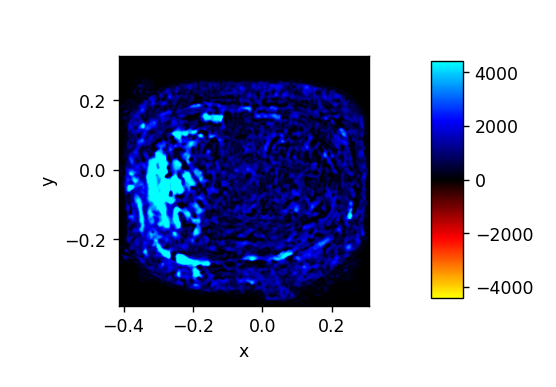

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [7]:
example.eval_baseline(frequency=40, polar=True, postprocess=True)
example.view('base', ax_height=2, ax_width=2)

In [14]:
%autoreload
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=20, detach=True)

In [20]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=60,
    n_layers=4,
    n_hidden=128,
    polar_input=True,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (output): Linear(in_features=390, out_features=1, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=6, out_features=128, bias=True)
    (hidden1): Linear(in_features=134, out_features=128, bias=True)
    (hidden2): Linear(in_features=262, out_features=128, bias=True)
    (output): Linear(in_features=390, out_features=1, bias=True)
  )
)

In [21]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-8],
    pde_warmup_iters=5000,
    pde_step_iters=1000,
    pde_init_weight=1e-19,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000158 s



In [22]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0011s (14.00%)
Model time/iter: 0.0007s (8.71%)
Loss time/iter:  0.0063s (77.29%)
Total time/iter: 0.0081s
Total time: 0.8108s
1k iters time: 0.14m
10k iters time: 1.35m
100k iters time: 0.23h


<IPython.core.display.Javascript object>


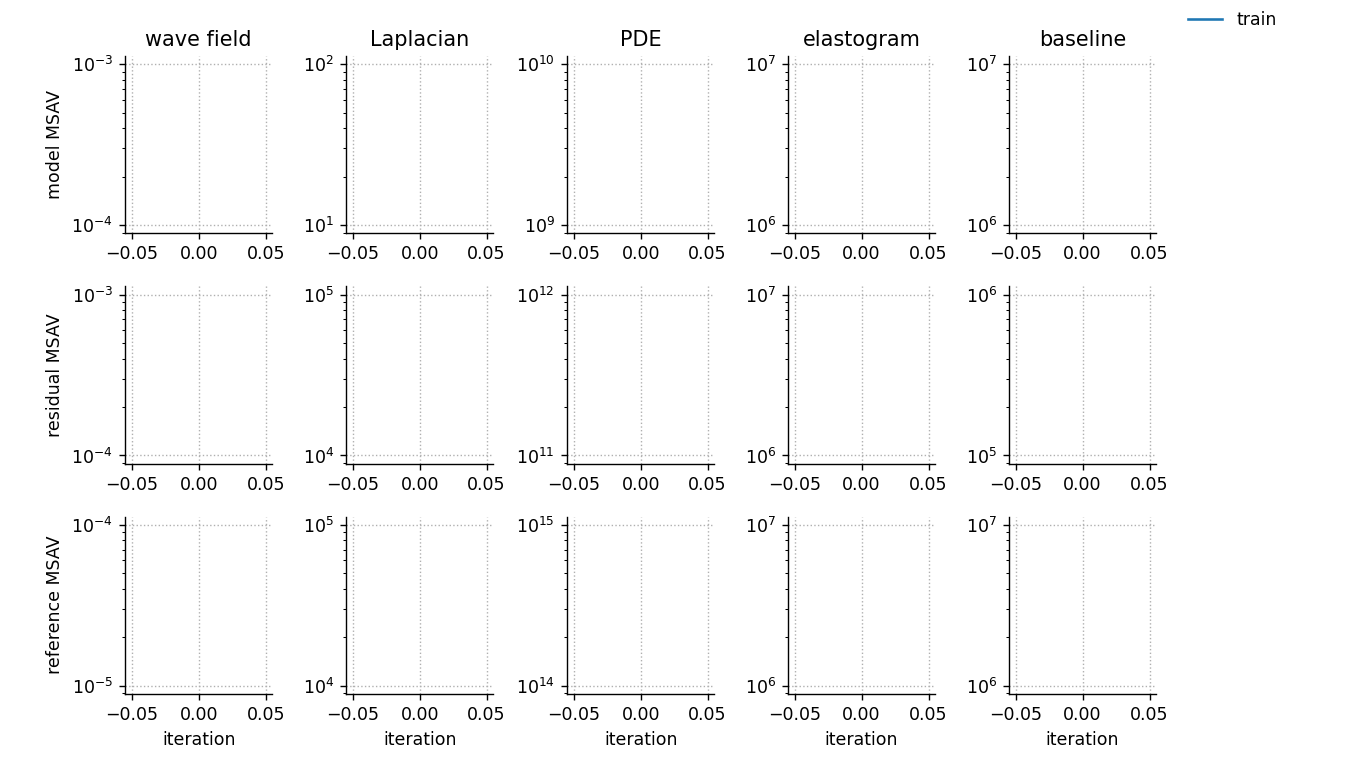

<IPython.core.display.Javascript object>


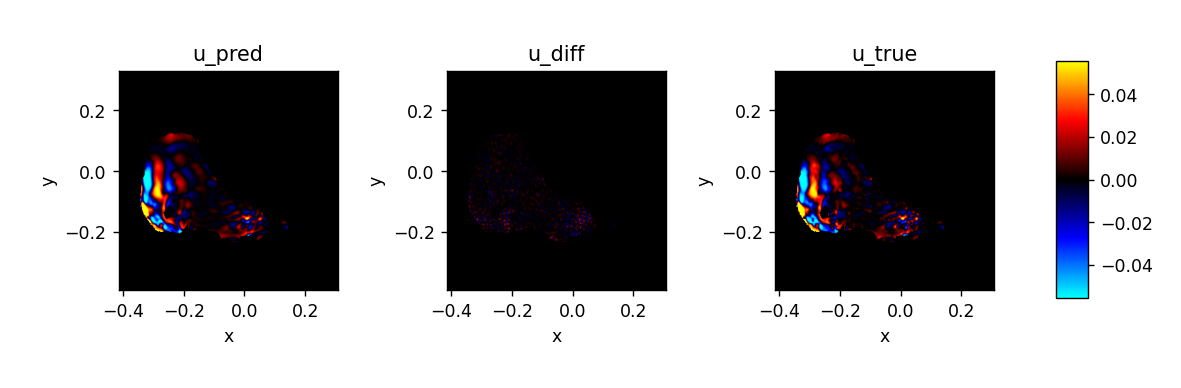

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


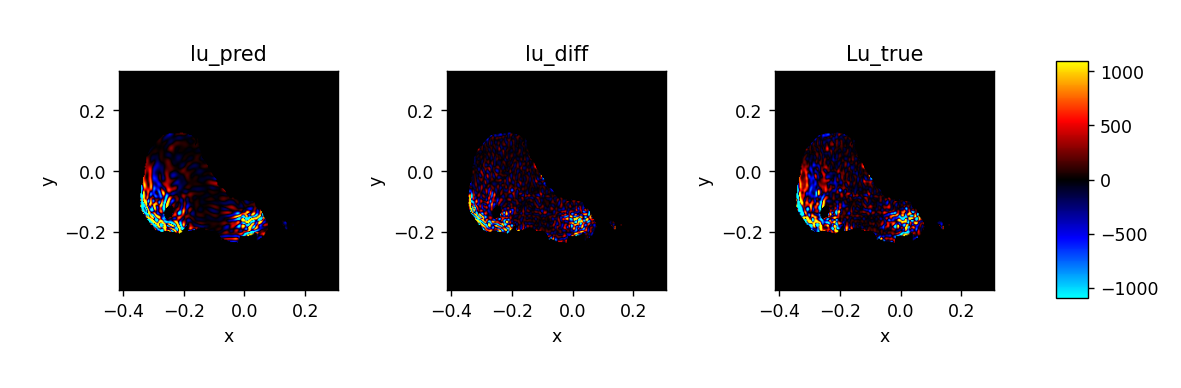

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


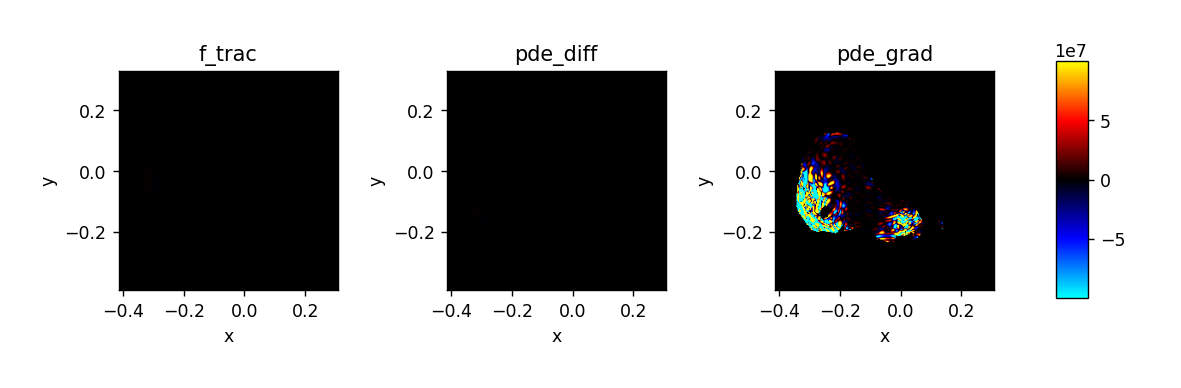

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


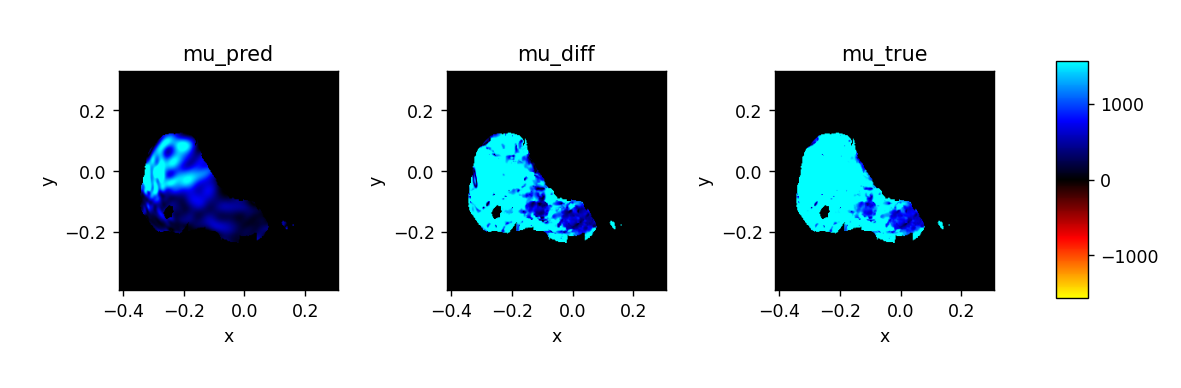

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

<IPython.core.display.Javascript object>


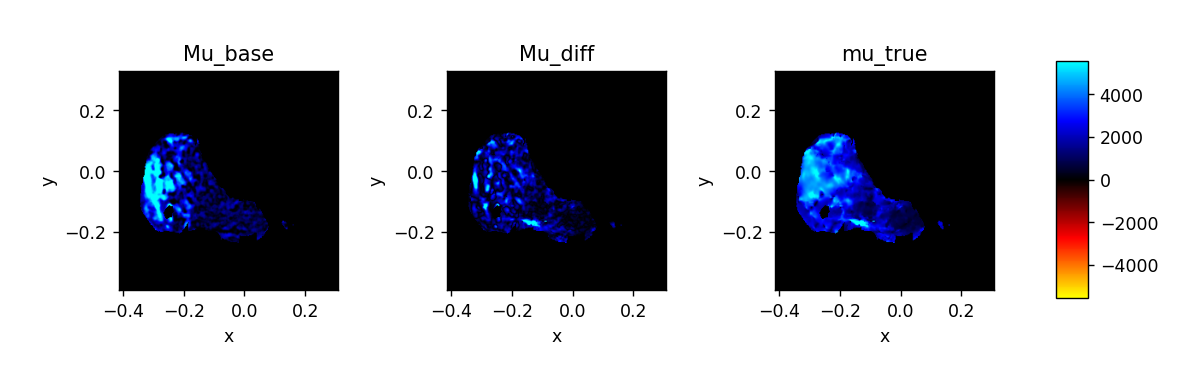

interactive(children=(SelectionSlider(description='part', options=(('abs', 0), ('angle', 1)), value=0), Select…

In [23]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [4.59e-03, 0.00e+00, 0.00e+00]    [4.63e-03, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


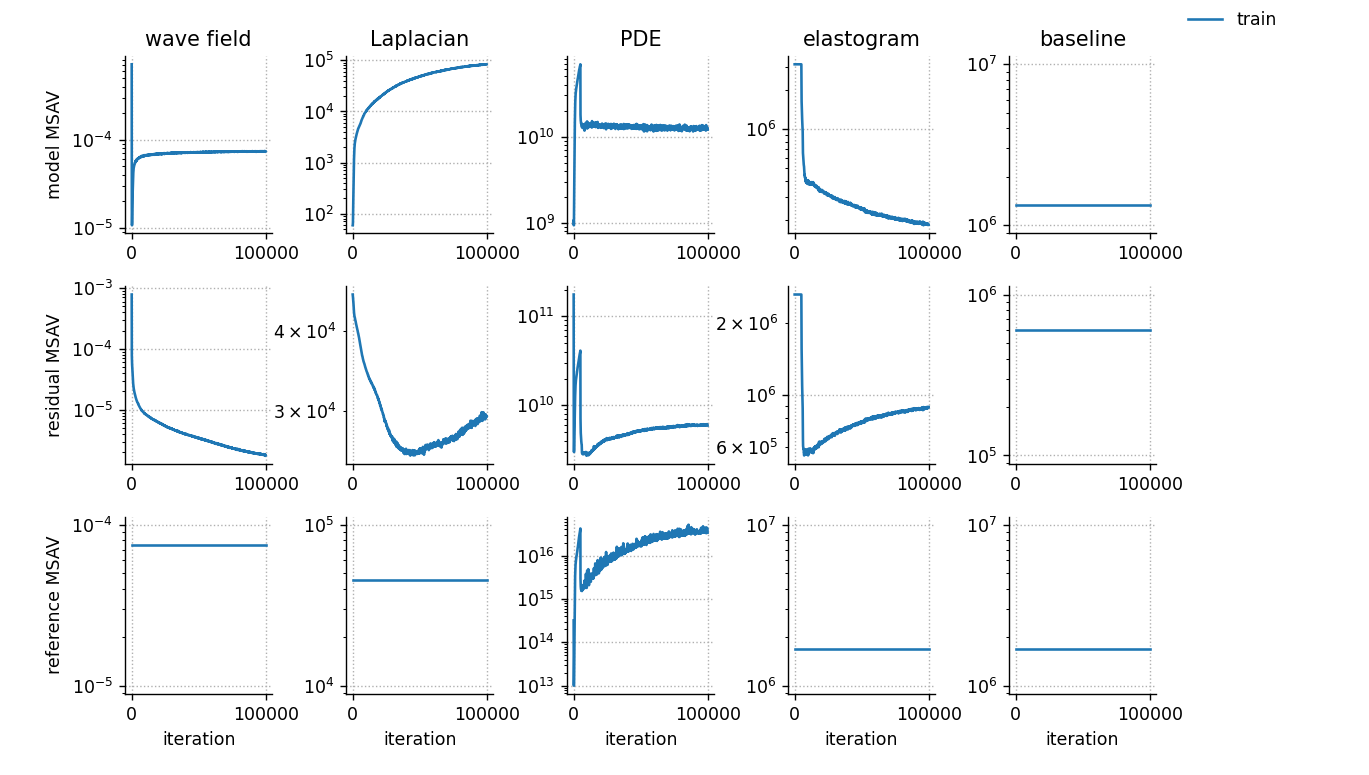

Time spent testing: 15.9887 (22.64%)
Time spent testing: 14.9884 (34.80%)
Time spent testing: 15.1593 (43.55%)
Time spent testing: 15.0974 (49.05%)
Time spent testing: 15.1948 (52.72%)
Time spent testing: 15.1027 (56.61%)
Time spent testing: 15.3998 (58.75%)
Time spent testing: 15.1438 (61.42%)
Time spent testing: 15.2928 (62.94%)
Time spent testing: 15.2191 (64.25%)
1000      [1.53e-04, 0.00e+00, 0.00e+00]    [1.64e-04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 15.3507 (65.62%)
Time spent testing: 15.5284 (66.68%)
Time spent testing: 15.1722 (68.05%)
Time spent testing: 15.2778 (69.07%)
Time spent testing: 15.1496 (70.17%)
Time spent testing: 14.9424 (71.15%)
Time spent testing: 15.2783 (71.71%)
Time spent testing: 15.0412 (72.53%)
Time spent testing: 15.1196 (72.66%)
Time spent testing: 15.2970 (73.29%)
2000      [9.44e-05, 0.00e+00, 0.00e+00]    [1.08e-04, 0.00e+00, 0.00e+00]    []  
Time spent testing: 15.3254 (73.59%)
Time spent testing: 15.5549 (73.71%)
Time spent testing: 

Time spent testing: 15.9048 (82.65%)
Time spent testing: 15.7915 (82.63%)
Time spent testing: 15.8507 (82.59%)
Time spent testing: 15.7897 (82.58%)
Time spent testing: 15.8227 (82.55%)
Time spent testing: 15.7545 (82.59%)
Time spent testing: 15.9850 (82.56%)
Time spent testing: 15.8267 (82.60%)
19000     [3.11e-05, 0.00e+00, 2.20e+02]    [3.12e-05, 0.00e+00, 2.69e+02]    []  
Time spent testing: 16.0051 (82.57%)
Time spent testing: 15.9811 (82.56%)
Time spent testing: 16.0725 (82.55%)
Time spent testing: 16.1574 (82.53%)
Time spent testing: 15.8622 (82.56%)
Time spent testing: 16.1319 (82.54%)
Time spent testing: 15.8726 (82.58%)
Time spent testing: 16.0614 (82.58%)
Time spent testing: 16.2593 (82.57%)
Time spent testing: 16.0586 (82.57%)
20000     [4.01e-05, 0.00e+00, 2.03e+02]    [2.99e-05, 0.00e+00, 2.65e+02]    []  
Time spent testing: 16.4026 (82.56%)
Time spent testing: 15.8703 (82.60%)
Time spent testing: 15.9938 (82.64%)
Time spent testing: 15.8656 (82.69%)
Time spent testing: 

Time spent testing: 16.5490 (83.48%)
Time spent testing: 15.9663 (83.46%)
Time spent testing: 16.5496 (83.48%)
Time spent testing: 15.9647 (83.46%)
Time spent testing: 16.7544 (83.47%)
Time spent testing: 16.1461 (83.46%)
37000     [2.41e-05, 0.00e+00, 2.21e+02]    [2.01e-05, 0.00e+00, 2.65e+02]    []  
Time spent testing: 16.9567 (83.45%)
Time spent testing: 16.0726 (83.47%)
Time spent testing: 16.9848 (83.45%)
Time spent testing: 15.8049 (83.47%)
Time spent testing: 16.6618 (83.47%)
Time spent testing: 16.0908 (83.48%)
Time spent testing: 16.8961 (83.49%)
Time spent testing: 16.2973 (83.50%)
Time spent testing: 16.3777 (83.52%)
Time spent testing: 15.8429 (83.54%)
38000     [2.35e-05, 0.00e+00, 2.97e+02]    [2.06e-05, 0.00e+00, 2.60e+02]    []  
Time spent testing: 16.5012 (83.56%)
Time spent testing: 15.8897 (83.55%)
Time spent testing: 16.8624 (83.53%)
Time spent testing: 15.8961 (83.53%)
Time spent testing: 16.7794 (83.52%)
Time spent testing: 15.9440 (83.53%)
Time spent testing: 

Time spent testing: 17.1682 (83.88%)
Time spent testing: 16.2544 (83.90%)
Time spent testing: 17.3896 (83.91%)
Time spent testing: 16.2964 (83.92%)
55000     [1.58e-05, 0.00e+00, 3.54e+02]    [1.57e-05, 0.00e+00, 2.97e+02]    []  
Time spent testing: 17.1408 (83.91%)
Time spent testing: 16.5059 (83.92%)
Time spent testing: 17.4229 (83.91%)
Time spent testing: 16.6528 (83.92%)
Time spent testing: 17.5364 (83.92%)
Time spent testing: 16.8731 (83.91%)
Time spent testing: 17.7255 (83.92%)
Time spent testing: 16.8457 (83.92%)
Time spent testing: 17.3813 (83.93%)
Time spent testing: 16.8148 (83.93%)
56000     [1.76e-05, 0.00e+00, 2.89e+02]    [1.62e-05, 0.00e+00, 2.91e+02]    []  
Time spent testing: 17.2200 (83.95%)
Time spent testing: 16.4480 (83.96%)
Time spent testing: 17.4440 (83.97%)
Time spent testing: 16.3460 (83.98%)
Time spent testing: 17.2753 (83.98%)
Time spent testing: 16.4951 (83.99%)
Time spent testing: 17.4110 (83.98%)
Time spent testing: 16.4861 (83.99%)
Time spent testing: 

Time spent testing: 17.9879 (84.44%)
Time spent testing: 17.6140 (84.44%)
73000     [1.58e-05, 0.00e+00, 3.40e+02]    [1.26e-05, 0.00e+00, 3.40e+02]    []  
Time spent testing: 17.8376 (84.45%)
Time spent testing: 17.3966 (84.44%)
Time spent testing: 18.0082 (84.45%)
Time spent testing: 17.4667 (84.45%)
Time spent testing: 18.2187 (84.46%)
Time spent testing: 17.1594 (84.47%)
Time spent testing: 17.9037 (84.48%)
Time spent testing: 17.2290 (84.49%)
Time spent testing: 17.8259 (84.48%)
Time spent testing: 17.2699 (84.49%)
74000     [1.26e-05, 0.00e+00, 3.62e+02]    [1.25e-05, 0.00e+00, 3.35e+02]    []  
Time spent testing: 18.0466 (84.49%)
Time spent testing: 17.3044 (84.48%)
Time spent testing: 17.8812 (84.48%)
Time spent testing: 17.4452 (84.47%)
Time spent testing: 18.0208 (84.48%)
Time spent testing: 17.9626 (84.47%)
Time spent testing: 18.1058 (84.48%)
Time spent testing: 17.5794 (84.47%)
Time spent testing: 17.9046 (84.48%)
Time spent testing: 17.6426 (84.47%)
75000     [1.26e-05,

91000     [1.14e-05, 0.00e+00, 3.02e+02]    [9.89e-06, 0.00e+00, 3.71e+02]    []  
Time spent testing: 17.8378 (84.73%)
Time spent testing: 18.4854 (84.74%)
Time spent testing: 18.1624 (84.73%)
Time spent testing: 18.5910 (84.74%)
Time spent testing: 18.1490 (84.74%)
Time spent testing: 18.6128 (84.74%)
Time spent testing: 18.0933 (84.74%)
Time spent testing: 18.6144 (84.75%)
Time spent testing: 18.0168 (84.74%)
Time spent testing: 18.5573 (84.75%)
92000     [1.27e-05, 0.00e+00, 3.58e+02]    [1.00e-05, 0.00e+00, 3.69e+02]    []  
Time spent testing: 18.1655 (84.75%)
Time spent testing: 19.0528 (84.75%)
Time spent testing: 17.8774 (84.76%)
Time spent testing: 18.5421 (84.77%)
Time spent testing: 17.7645 (84.78%)
Time spent testing: 18.5203 (84.78%)
Time spent testing: 17.8754 (84.79%)
Time spent testing: 18.6169 (84.78%)
Time spent testing: 17.8949 (84.79%)
Time spent testing: 18.7302 (84.79%)
93000     [1.05e-05, 0.00e+00, 3.18e+02]    [9.14e-06, 0.00e+00, 3.49e+02]    []  
Time spent 

(<deepxde.model.LossHistory at 0x1515a9f940d0>,
 <deepxde.model.TrainState at 0x1515ab2b4f10>)

In [24]:
model.train(100000, callbacks=[test_eval])